In [1]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

import sympy as sp
import numpy as np

In [2]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)
n_init, order, r = get_processed_and_shifted_recurrence(laplace2d)

In [3]:
def scale_recurrence(r):
    #We want to subsitute s(i) r^i_{ct} = g(i)
    g = sp.Function("g")
    s = sp.Function("s")
    n = sp.symbols("n")
    rct = sp.symbols("r_{ct}")

    r_new = r*rct**n
    for i in range(order):
        r_new = r_new.subs(s(n-i),g(n-i)/(rct**(n-i)))

    return r_new

In [4]:
r_new = scale_recurrence(r)

In [5]:
max_abs = .0000001
var = _make_sympy_vec("x", 2)
rct = sp.symbols("r_{ct}")
g = sp.Function("g")
n = sp.symbols("n")

In [6]:
r_new

(-1)**(n + 1)*r_{ct}**n*((-1)**(n - 3)*r_{ct}**(3 - n)*(n + (n - 2)**3 - 2*(n - 2)**2 - 2)*g(n - 3)/(x0**3 + x0*x1**2) + (-1)**(n - 2)*r_{ct}**(2 - n)*(-n + 3*(n - 2)**2 + 2)*g(n - 2)/(x0**2 + x1**2) + (-1)**(n - 1)*r_{ct}**(1 - n)*(3*x0**2*(n - 2) + x0**2 + x1**2*(n - 2) - x1**2)*g(n - 1)/(x0**3 + x0*x1**2))

In [14]:
from sumpy.recurrence import get_recurrence, _extract_idx_terms_from_recurrence
pw = 5
x_coord = -10**(-pw) * 1
y_coord = 1
var = _make_sympy_vec("x", 2)
coord_dict = {var[0]: x_coord, var[1]: y_coord}

get_recurrence(r_new.subs(rct, var[0]).subs(coord_dict), 6)

3.59999999964e-9*g(3) - 4.39999999956e-9*g(4) + 3.000000001*g(5)

In [16]:
get_recurrence(r_new.subs(rct, 1).subs(coord_dict), 7)

-7999999.9992*g(4) - 69.999999993*g(5) - 400000.00012*g(6)

In [17]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs
derivs = compute_derivatives(15)

In [65]:
def evaluate_recurrence(coord_dict, rct_val, recur, p):
    subs_dict = {}
    subs_dict[g(0)] = derivs[0].subs(coord_dict).subs(rct, rct_val)
    subs_dict[g(1)] = derivs[1].subs(coord_dict).subs(rct, rct_val) * rct_val
    var = _make_sympy_vec("x", 2)
    for i in range(2, p):
        subs_dict[g(i)] = get_recurrence(recur.subs(rct, var[0]), i).subs(subs_dict).subs(coord_dict).subs(rct, rct_val)
        print((get_recurrence(recur.subs(rct, var[0]), i).subs(coord_dict).subs(rct, rct_val)))
    return np.array(list(subs_dict.values()))

In [66]:
def evaluate_true(coord_dict, rct_val, p):
    retMe = []
    for i in range(p):
        retMe.append((derivs[i]*rct_val**i).subs(coord_dict))
    return np.array(retMe)

In [70]:
def compute_error(pw):
    if pw == 0:
        x_coord  = 0
    else:
        x_coord = -10**(-pw) * 1
    y_coord = 1
    var = _make_sympy_vec("x", 2)
    coord_dict = {var[0]: x_coord, var[1]: y_coord}

    rct_val = x_coord
    exp = evaluate_recurrence(coord_dict, rct_val, r_new, 14)
    true = evaluate_true(coord_dict, rct_val, 14)
    print(exp)
    print(true)
    return np.abs(exp-true)/np.abs(true)

In [71]:
import matplotlib.pyplot as plt

In [72]:
compute_error(5)

-0.9999999998*g(1)
-1.9999999998e-10*g(1) + 3.9999999996e-10*g(2)
1.9999999998e-10*g(1) - 9.999999999e-10*g(2) + 1.0000000006*g(3)
1.19999999988e-9*g(2) - 2.39999999976e-9*g(3) + 2.0000000008*g(4)
3.59999999964e-9*g(3) - 4.39999999956e-9*g(4) + 3.000000001*g(5)
7.9999999992e-9*g(4) - 6.9999999993e-9*g(5) + 4.0000000012*g(6)
1.49999999985e-8*g(5) - 1.019999999898e-8*g(6) + 5.0000000014*g(7)
2.519999999748e-8*g(6) - 1.39999999986e-8*g(7) + 6.0000000016*g(8)
3.919999999608e-8*g(7) - 1.839999999816e-8*g(8) + 7.0000000018*g(9)
5.759999999424e-8*g(8) - 2.339999999766e-8*g(9) + 8.000000002*g(10)
8.09999999919e-8*g(9) - 2.89999999971e-8*g(10) + 9.0000000022*g(11)
1.09999999989e-7*g(10) - 3.519999999648e-8*g(11) + 10.0000000024*g(12)
[5.00000041357686e-11 -9.99999999900000e-11 9.99999999700000e-11
 5.99999999800000e-20 -5.99999999400000e-20 -1.19999976306405e-28
 1.20000070576785e-28 2.83819141183544e-34 1.41607170595089e-33
 8.49945423577581e-33 5.94961796507997e-32 4.75969437208068e-31
 4.283

array([0, 0, 1.29246970750185e-16, 2.00617702607210e-16,
       4.01235405481909e-16, 1.96746626133391e-7, 5.90239878479149e-7,
       562.133217309775, 2810.66609335069, 2342221740344.40,
       16395552242621.5, 1.19240379600967e+22, 1.07316342199171e+23,
       6.87925267550574e+31], dtype=object)

1.0*(x0**2 - x1**2)*g(1)/(x0**3 + x0*x1**2)
4.0*x0**2*g(2)/(x0**3 + x0*x1**2) - 2.0*g(1)/(x0**2 + x1**2)
1.0*(7*x0**2 + x1**2)*g(3)/(x0**3 + x0*x1**2) + 2.0*g(1)/(x0**3 + x0*x1**2) - 10.0*g(2)/(x0**2 + x1**2)
1.0*(10*x0**2 + 2*x1**2)*g(4)/(x0**3 + x0*x1**2) + 12.0*g(2)/(x0**3 + x0*x1**2) - 24.0*g(3)/(x0**2 + x1**2)
1.0*(13*x0**2 + 3*x1**2)*g(5)/(x0**3 + x0*x1**2) + 36.0*g(3)/(x0**3 + x0*x1**2) - 44.0*g(4)/(x0**2 + x1**2)
1.0*(16*x0**2 + 4*x1**2)*g(6)/(x0**3 + x0*x1**2) + 80.0*g(4)/(x0**3 + x0*x1**2) - 70.0*g(5)/(x0**2 + x1**2)
1.0*(19*x0**2 + 5*x1**2)*g(7)/(x0**3 + x0*x1**2) + 150.0*g(5)/(x0**3 + x0*x1**2) - 102.0*g(6)/(x0**2 + x1**2)
1.0*(22*x0**2 + 6*x1**2)*g(8)/(x0**3 + x0*x1**2) + 252.0*g(6)/(x0**3 + x0*x1**2) - 140.0*g(7)/(x0**2 + x1**2)
1.0*(25*x0**2 + 7*x1**2)*g(9)/(x0**3 + x0*x1**2) + 392.0*g(7)/(x0**3 + x0*x1**2) - 184.0*g(8)/(x0**2 + x1**2)
1.0*(28*x0**2 + 8*x1**2)*g(10)/(x0**3 + x0*x1**2) + 576.0*g(8)/(x0**3 + x0*x1**2) - 234.0*g(9)/(x0**2 + x1**2)
1.0*(31*x0**2 + 9*x1**2)*g

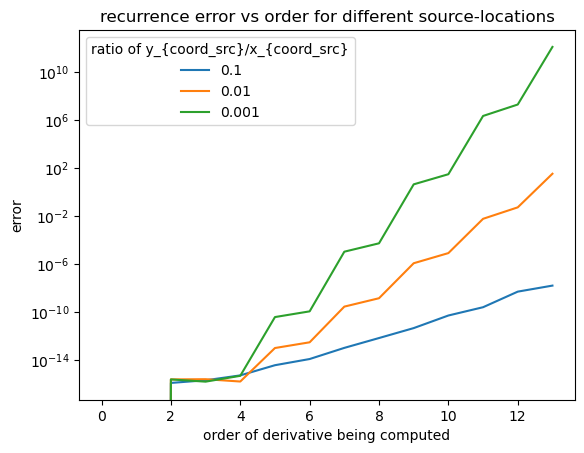

In [ ]:
x_plot = [i for i in range(len(compute_error(0)))]
for i in range(1, 4):
    plt.semilogy(x_plot, compute_error(i), label=str(10**(-i)))
plt.xlabel("order of derivative being computed")
plt.ylabel("error")
plt.title("recurrence error vs order for different source-locations")
plt.legend(title='ratio of y_{coord_src}/x_{coord_src}')
plt.show()

In [ ]:
(1.0/4.4**10) * 4.4**10 - 1

0.0